# Random Forest Baseline Generation

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, RocCurveDisplay, classification_report
from sklearn.preprocessing import LabelBinarizer
from scipy.stats import mode
import matplotlib.pyplot as plt
from itertools import cycle
import joblib

In [2]:
synthetic_data = pd.read_csv('syn_data.csv', index_col=0)
synthetic_data

,hospital_stay_length,gcs,nb_acte,gender,entry,output,entry_code,ica,ttt,ica_therapy,...,ivh,age,nimodipine,paracetamol,nad,corotrop,morphine,dve,atl,iot
0,41.089445,17.086233,34.307297,0,0,0.0,0,0,0,0,...,0,38.712762,-1,-1,-1,-1,-1,-1,-1,25
1,21.702298,18.805639,133.523169,0,1,1.0,2,2,1,0,...,0,58.565461,89,58,26,-1,-1,116,-1,-1
2,4.627752,19.516216,85.648533,0,2,0.0,1,2,2,0,...,1,76.432889,12,-1,-1,-1,-1,40,-1,-1
3,12.830087,19.940518,17.982208,1,1,2.0,3,4,2,0,...,1,87.351874,29,-1,-1,-1,-1,-1,-1,53
4,75.675201,21.665547,132.859962,0,3,1.0,4,5,2,0,...,0,75.440254,26,-1,-1,-1,-1,79,-1,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,23.668646,18.302874,41.950003,1,5,2.0,3,3,2,0,...,1,83.381334,22,-1,-1,-1,-1,-1,-1,40
9996,33.643450,20.634914,84.554423,0,1,1.0,1,5,1,0,...,0,49.631746,-1,-1,-1,-1,-1,24,-1,56
9997,18.122234,15.604823,4.792264,1,5,2.0,1,6,1,0,...,0,53.602286,24,-1,-1,-1,-1,-1,-1,55
9998,43.964242,18.368290,4.802513,1,2,1.0,1,3,2,0,...,1,82.388699,26,-1,-1,-1,-1,-1,-1,48


In [3]:
# replace all -1 with NaN
synthetic_data = synthetic_data.replace(-1, np.nan)

# for all columns with missing values, fill with the mode
synthetic_data = synthetic_data.fillna(synthetic_data.mode().iloc[0])

synthetic_data

,hospital_stay_length,gcs,nb_acte,gender,entry,output,entry_code,ica,ttt,ica_therapy,...,ivh,age,nimodipine,paracetamol,nad,corotrop,morphine,dve,atl,iot
0,41.089445,17.086233,34.307297,0,0,0.0,0,0,0,0,...,0,38.712762,26.0,45.0,48.0,45.0,45.0,23.0,24.0,25.0
1,21.702298,18.805639,133.523169,0,1,1.0,2,2,1,0,...,0,58.565461,89.0,58.0,26.0,45.0,45.0,116.0,24.0,46.0
2,4.627752,19.516216,85.648533,0,2,0.0,1,2,2,0,...,1,76.432889,12.0,45.0,48.0,45.0,45.0,40.0,24.0,46.0
3,12.830087,19.940518,17.982208,1,1,2.0,3,4,2,0,...,1,87.351874,29.0,45.0,48.0,45.0,45.0,23.0,24.0,53.0
4,75.675201,21.665547,132.859962,0,3,1.0,4,5,2,0,...,0,75.440254,26.0,45.0,48.0,45.0,45.0,79.0,24.0,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,23.668646,18.302874,41.950003,1,5,2.0,3,3,2,0,...,1,83.381334,22.0,45.0,48.0,45.0,45.0,23.0,24.0,40.0
9996,33.643450,20.634914,84.554423,0,1,1.0,1,5,1,0,...,0,49.631746,26.0,45.0,48.0,45.0,45.0,24.0,24.0,56.0
9997,18.122234,15.604823,4.792264,1,5,2.0,1,6,1,0,...,0,53.602286,24.0,45.0,48.0,45.0,45.0,23.0,24.0,55.0
9998,43.964242,18.368290,4.802513,1,2,1.0,1,3,2,0,...,1,82.388699,26.0,45.0,48.0,45.0,45.0,23.0,24.0,48.0


In [ ]:
#random_state=42
X_train, X_test, y_train, y_test = train_test_split(synthetic_data.drop
                                                    (['output'], axis=1), synthetic_data['output'], test_size=0.2, random_state=24)

In [5]:
y_train.value_counts()

output
0.0    3520
1.0    3450
2.0    1030
Name: count, dtype: int64

In [6]:
n_runs = 2

f1s = []
f1_ws = []

y_pred = np.zeros((n_runs, len(y_test)))
y_probs = np.zeros((n_runs, len(y_test), 3))

for i in range(n_runs):
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    y_partical_pred = model.predict(X_test)

    f1 = round(f1_score(y_test, y_partical_pred, average="macro"), 2)
    f1s += [f1]
    f1_w = round(f1_score(y_test, y_partical_pred, average="weighted"), 2)
    f1_ws += [f1_w]
    print("Model", i, f1, "/", f1_w)

    y_pred[i] = y_partical_pred
    y_probs[i] = model.predict_proba(X_test)

print("AVG", sum(f1s)/len(f1s), "/", sum(f1_ws)/len(f1_ws))

Model 0 0.48 / 0.56
Model 1 0.49 / 0.56
AVG 0.485 / 0.56


In [7]:
y_pred = mode(y_pred, axis=0).mode

In [8]:
y_score = np.mean(y_probs, axis=0)

In [9]:
print(classification_report(y_test, y_pred, target_names=["Back2Home", "Reabilitation", "Death"]))

               precision    recall  f1-score   support

    Back2Home       0.59      0.71      0.64       894
Reabilitation       0.54      0.53      0.53       883
        Death       0.54      0.13      0.21       223

     accuracy                           0.56      2000
    macro avg       0.55      0.46      0.46      2000
 weighted avg       0.56      0.56      0.55      2000



In [10]:
accuracy = round(accuracy_score(y_test, y_pred), 2)
print("Accuracy:", accuracy)
precision = round(precision_score(y_test, y_pred, average="macro"), 2)
precision_w = round(precision_score(y_test, y_pred, average="weighted"), 2)
print("Precision:", precision, "/", precision_w)
recall = round(recall_score(y_test, y_pred, average="macro"), 2)
recall_w = round(recall_score(y_test, y_pred, average="weighted"), 2)
print("Recall:", recall, "/", recall_w)
f1_micro = round(f1_score(y_test, y_pred, average="micro"), 2)
f1 = round(f1_score(y_test, y_pred, average="macro"), 2)
f1_w = round(f1_score(y_test, y_pred, average="weighted"), 2)
print("F1 Score:", f1, "/", f1_w, "/", f1_micro)
print("F1 per class:", [round(i, 2) for i in f1_score(y_test, y_pred, average=None)])
print("AUC ROC:", round(roc_auc_score(y_test, y_score, multi_class='ovr'), 2))

Accuracy: 0.56
Precision: 0.55 / 0.56
Recall: 0.46 / 0.56
F1 Score: 0.46 / 0.55 / 0.56
F1 per class: [0.64, 0.53, 0.21]
AUC ROC: 0.73


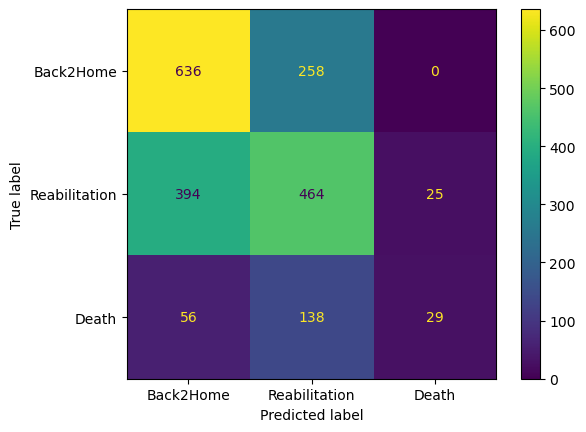

In [11]:
matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["Back2Home", "Reabilitation", "Death"])
disp.plot()
plt.show()

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [12]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape

(2000, 3)

In [13]:
label_binarizer.transform([0])

array([[1, 0, 0]])

In [14]:
class_of_interest = 0
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

0

In [15]:
print(f"y_score:\n{y_score[0:2,:]}")
print()
print(f"y_score.ravel():\n{y_score[0:2,:].ravel()}")

y_score:
[[0.575 0.4   0.025]
 [0.46  0.4   0.14 ]]

y_score.ravel():
[0.575 0.4   0.025 0.46  0.4   0.14 ]


In [16]:
micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.79


In [17]:
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.79


In [18]:
n_classes = 3

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.73


In [19]:
macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.73


In [20]:
macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="weighted",
)

print(f"W:\n{macro_roc_auc_ovr:.2f}")

W:
0.71


In [21]:
class_weights = [0.443396, 0.432075, 0.124529]

# Compute ROC curve and ROC area for each class with sample weights
for i in range(n_classes):
    sample_weight = np.ones(y_onehot_test.shape[0]) * class_weights[i]
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i], sample_weight=sample_weight)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Interpolation grid
fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
weighted_mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    interp_tpr = np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation
    weighted_mean_tpr += class_weights[i] * interp_tpr

# Compute AUC for the weighted macro-average
fpr["weighted_macro"] = fpr_grid
tpr["weighted_macro"] = weighted_mean_tpr
roc_auc["weighted_macro"] = auc(fpr["weighted_macro"], tpr["weighted_macro"])

print(f"Weighted Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['weighted_macro']:.2f}")


Weighted Macro-averaged One-vs-Rest ROC AUC score:
0.71


In [22]:

(np.ones(y_onehot_test.shape[0]) * class_weights[0]).shape

(2000,)

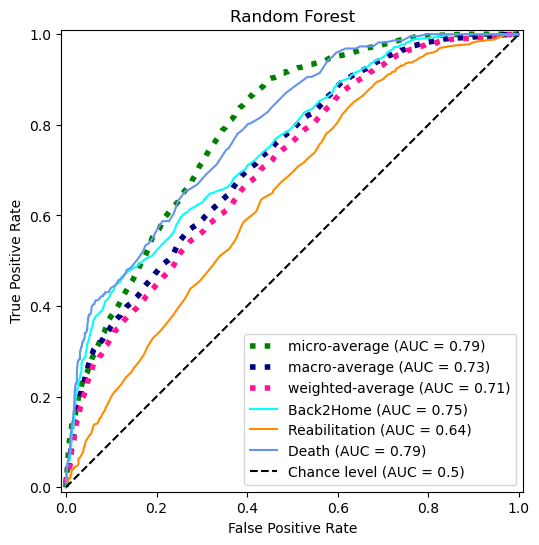

In [23]:
fig, ax = plt.subplots(figsize=(6, 6))

target_names = ["Back2Home", "Reabilitation", "Death"]

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average (AUC = {roc_auc['micro']:.2f})",
    color="green",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["weighted_macro"],
    tpr["weighted_macro"],
    label=f"weighted-average (AUC = {roc_auc['weighted_macro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"{target_names[class_id]}",
        color=color,
        ax=ax,
        plot_chance_level=(class_id == 2),
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Random Forest",
)

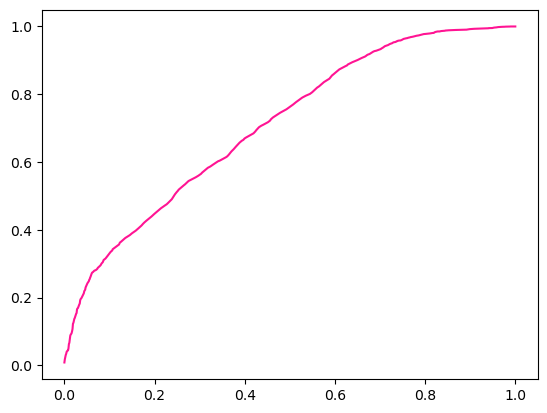

In [24]:
plt.plot(
    fpr["weighted_macro"],
    tpr["weighted_macro"],
    label=f"weighted-average (AUC = {roc_auc['weighted_macro']:.2f})",
    color="deeppink",
)